In [12]:
'''
Importación de librerías necesarias
'''
# Para analisis de datos
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re

# Para NLP (también se utiliza pandas, numpy y matplotlib)
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer, PorterStemmer
from nltk.probability import FreqDist
from wordcloud import WordCloud
from nltk.sentiment import SentimentIntensityAnalyzer
from nltk import ne_chunk, pos_tag
import seaborn as sns


In [13]:
# Cargar el dataset
df = pd.read_csv('/content/practica2/Datos.csv')

# Mostramos las primeras filas para entender la estructura de los datos
print("Estructura inicial del dataset:")
print(df.head())
print("\nInformación del dataset:")
print(df.info())

Estructura inicial del dataset:
                                        Course Title  Rating           Level  \
0                                  Fashion as Design     4.8  Beginner level   
1                             Modern American Poetry     4.4  Beginner level   
2                          Pixel Art for Video Games     4.5  Beginner level   
3    Distribución digital de la música independiente     NaN  Beginner level   
4  The Blues: Understanding and Performing an Ame...     4.8  Beginner level   

                       Duration           Schedule         Review  \
0      20 hours (approximately)  Flexible schedule  2,813 reviews   
1  Approx. 34 hours to complete  Flexible schedule    100 reviews   
2       9 hours (approximately)  Flexible schedule    227 reviews   
3   Approx. 8 hours to complete  Flexible schedule            NaN   
4  Approx. 11 hours to complete  Flexible schedule    582 reviews   

                                 What you will learn  \
0               

In [14]:
# Limpieza de los datos
print("\n--- Procesamiento y limpieza de datos ---")

# Verificamos valores faltantes
print("\nValores faltantes por columna:")
print(df.isnull().sum())

# Limpieza de la columna Rating
def clean_rating(rating):
    if pd.isna(rating):
        return np.nan
    try:
        return float(rating)
    except:
        return np.nan

df['Rating'] = df['Rating'].apply(clean_rating)

# Limpieza de la columna Duration
def extract_hours(duration):
    if pd.isna(duration):
        return np.nan

    # Buscar patrón de horas
    hours_match = re.search(r'(\d+)\s*hours?', str(duration))
    if hours_match:
        return float(hours_match.group(1))

    # Si no hay horas especificadas
    return np.nan

df['Duration_Hours'] = df['Duration'].apply(extract_hours)

# Limpieza de la columna Review
def extract_review_count(review):
    if pd.isna(review):
        return np.nan

    # Buscar números en el texto
    numbers = re.findall(r'\d+', str(review))
    if numbers:
        # Si hay números, unirlos y convertir a entero
        try:
            return int(''.join(numbers))
        except:
            return np.nan

    return np.nan

df['Review_Count'] = df['Review'].apply(extract_review_count)

# Filtrar datos para el gráfico de dispersión (eliminar NaN)
scatter_data = df.dropna(subset=['Duration_Hours', 'Review_Count'])

# Utilizamos solo caracteres ASCII en los títulos para evitar problemas con las fuentes
def clean_title(title):
    if isinstance(title, str):
        # Eliminar caracteres no ASCII
        return ''.join(c for c in title if ord(c) < 128)
    return "Unknown"

scatter_data['Clean_Title'] = scatter_data['Course Title'].apply(clean_title)

# Estadísticas básicas después de la limpieza
print("\nEstadísticas después de la limpieza:")
print(df[['Rating', 'Duration_Hours', 'Review_Count']].describe())


--- Procesamiento y limpieza de datos ---

Valores faltantes por columna:
Course Title              0
Rating                 1439
Level                  1265
Duration                262
Schedule                683
Review                 1443
What you will learn    4611
Skill gain                0
Modules                   0
Instructor                0
Offered By                0
Keyword                   0
Course Url                0
dtype: int64

Estadísticas después de la limpieza:
            Rating  Duration_Hours   Review_Count
count  8156.000000     9331.000000    8152.000000
mean      4.651533       14.611296    2265.173577
std       0.240674       10.538162   10635.102252
min       1.500000        1.000000       5.000000
25%       4.600000        9.000000      73.000000
50%       4.700000       11.000000     312.000000
75%       4.800000       18.000000    1238.000000
max       5.000000      133.000000  225830.000000


<ipython-input-14-384a022177b7>:62: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  scatter_data['Clean_Title'] = scatter_data['Course Title'].apply(clean_title)


In [15]:
# Extraer solo el nivel del curso (eliminar "level" de la cadena)
def clean_level(level):
    if pd.isna(level):
        return "Unknown"
    level_match = re.search(r'(Beginner|Intermediate|Advanced)', str(level))
    if level_match:
        return level_match.group(1)
    return "Unknown"

df['Level_Clean'] = df['Level'].apply(clean_level)

# Mostrar los datos procesados
print("\nDatos procesados:")
print(df[['Course Title', 'Rating', 'Level_Clean', 'Duration_Hours', 'Review_Count', 'Offered By']].head())


Datos procesados:
                                        Course Title  Rating Level_Clean  \
0                                  Fashion as Design     4.8    Beginner   
1                             Modern American Poetry     4.4    Beginner   
2                          Pixel Art for Video Games     4.5    Beginner   
3    Distribución digital de la música independiente     NaN    Beginner   
4  The Blues: Understanding and Performing an Ame...     4.8    Beginner   

   Duration_Hours  Review_Count  \
0            20.0        2813.0   
1            34.0         100.0   
2             9.0         227.0   
3             8.0           NaN   
4            11.0         582.0   

                                       Offered By  
0                    ['The Museum of Modern Art']  
1  ['University of Illinois at Urbana-Champaign']  
2                   ['Michigan State University']  
3                        ['SAE Institute México']  
4                     ['University of Rochester']  


In [16]:
print("\n--- Generando visualizaciones ---")

# Configuración general de las visualizaciones
plt.style.use('seaborn-v0_8-darkgrid')
colors = ['#3498db', '#2ecc71', '#e74c3c', '#f39c12', '#9b59b6']


--- Generando visualizaciones ---


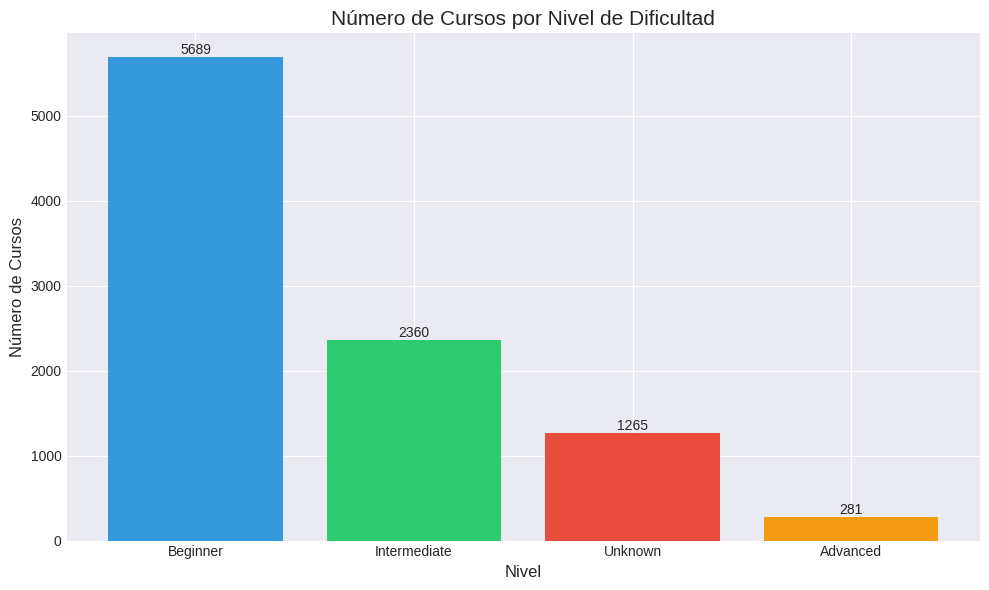

In [17]:
# 1. Gráfica de barras de cursos por nivel
plt.figure(figsize=(10, 6))
level_counts = df['Level_Clean'].value_counts()
bars = plt.bar(level_counts.index, level_counts.values, color=colors[:len(level_counts)])

# Añadir etiquetas y valores encima de las barras
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height + 0.1,
            f'{height}', ha='center', va='bottom')

plt.title('Número de Cursos por Nivel de Dificultad', fontsize=15)
plt.xlabel('Nivel', fontsize=12)
plt.ylabel('Número de Cursos', fontsize=12)
plt.xticks(rotation=0)
plt.tight_layout()
plt.savefig('cursos_por_nivel.png')
plt.show()

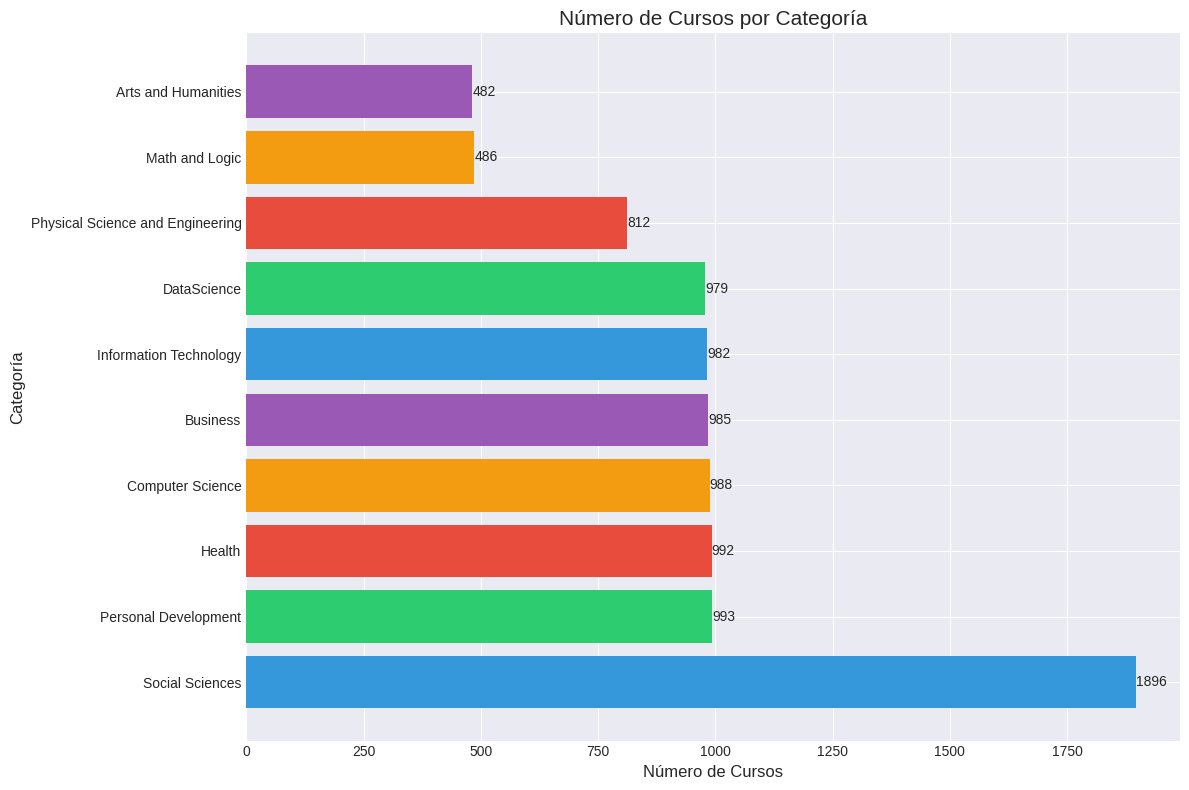

In [18]:
# 2. Gráfica de barras horizontal por categoría
plt.figure(figsize=(12, 8))
category_counts = df['Keyword'].value_counts()
bars = plt.barh(category_counts.index, category_counts.values, color=colors[:len(category_counts)])

# Añadir valores al final de las barras
for bar in bars:
    width = bar.get_width()
    plt.text(width + 0.1, bar.get_y() + bar.get_height()/2.,
            f'{width}', ha='left', va='center')

plt.title('Número de Cursos por Categoría', fontsize=15)
plt.xlabel('Número de Cursos', fontsize=12)
plt.ylabel('Categoría', fontsize=12)
plt.tight_layout()
plt.savefig('cursos_por_categoria.png')
plt.show()

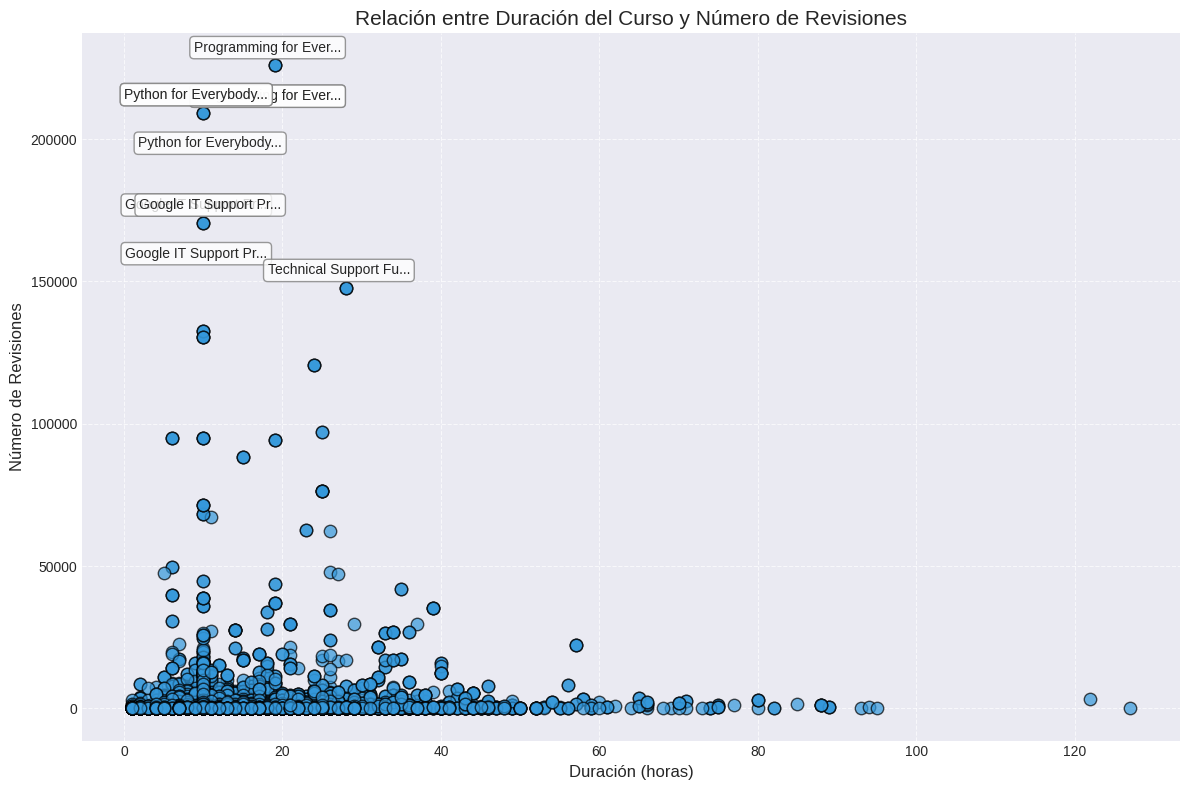

In [19]:
# 3. Gráfico de dispersión entre duración y número de revisiones (mejorado)
plt.figure(figsize=(12, 8))  # Aumentamos el tamaño para mejor visualización

# Crear gráfico de dispersión
plt.scatter(scatter_data['Duration_Hours'], scatter_data['Review_Count'],
           alpha=0.7, s=80, c='#3498db', edgecolors='black')

plt.title('Relación entre Duración del Curso y Número de Revisiones', fontsize=15)
plt.xlabel('Duración (horas)', fontsize=12)
plt.ylabel('Número de Revisiones', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.7)

# Añadir etiquetas solo para los puntos más relevantes y evitar solapamiento
# Ordenamos por número de revisiones para priorizar los cursos más populares
top_courses = scatter_data.sort_values(by='Review_Count', ascending=False).head(10)

for i, row in top_courses.iterrows():
    if row['Review_Count'] > 1000:  # Solo para cursos con más de 1000 revisiones
        short_title = row['Clean_Title'][:20]
        if len(row['Clean_Title']) > 20:
            short_title += '...'

        # Posicionamiento más inteligente para evitar solapamiento
        y_offset = 10 if i % 2 == 0 else -25  # Alternamos arriba/abajo
        x_offset = 5 if i % 3 == 0 else -5    # Variamos también horizontalmente

        plt.annotate(short_title,
                    (row['Duration_Hours'], row['Review_Count']),
                    textcoords="offset points",
                    xytext=(x_offset, y_offset),
                    ha='center',
                    bbox=dict(boxstyle="round,pad=0.3", fc="white", ec="gray", alpha=0.8))

plt.tight_layout()
plt.savefig('duracion_vs_revisiones.png')
plt.show()

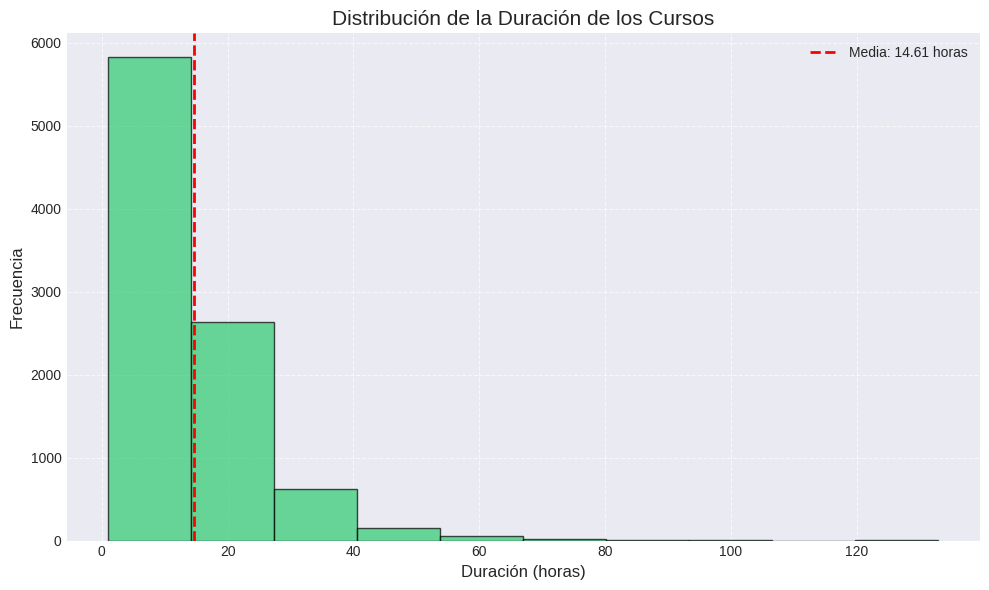

In [20]:
# 4. Histograma de duración de cursos
plt.figure(figsize=(10, 6))
duration_data = df['Duration_Hours'].dropna()

plt.hist(duration_data, bins=10, color='#2ecc71', edgecolor='black', alpha=0.7)
plt.axvline(duration_data.mean(), color='red', linestyle='dashed', linewidth=2,
            label=f'Media: {duration_data.mean():.2f} horas')

plt.title('Distribución de la Duración de los Cursos', fontsize=15)
plt.xlabel('Duración (horas)', fontsize=12)
plt.ylabel('Frecuencia', fontsize=12)
plt.legend()
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.savefig('histograma_duracion.png')
plt.show()

<ipython-input-21-893d64200c9a>:7: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([boxplot_data[boxplot_data['Level_Clean'] == level]['Rating']


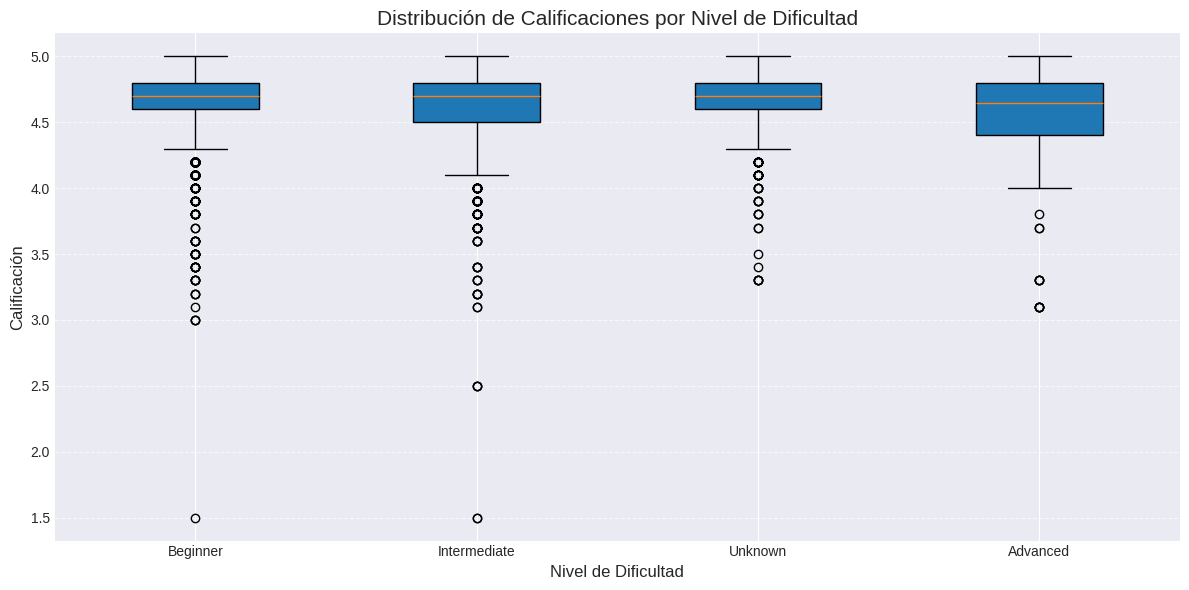

In [21]:
# 5. Boxplot de calificaciones por nivel de dificultad
plt.figure(figsize=(12, 6))
# Filtrar para tener datos válidos
boxplot_data = df.dropna(subset=['Rating', 'Level_Clean'])

# Crear el boxplot
plt.boxplot([boxplot_data[boxplot_data['Level_Clean'] == level]['Rating']
             for level in boxplot_data['Level_Clean'].unique()],
            labels=boxplot_data['Level_Clean'].unique(),
            patch_artist=True)

plt.title('Distribución de Calificaciones por Nivel de Dificultad', fontsize=15)
plt.xlabel('Nivel de Dificultad', fontsize=12)
plt.ylabel('Calificación', fontsize=12)
plt.grid(True, axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.savefig('boxplot_calificaciones.png')
plt.show()

In [22]:
'''
Aqui inicia lo de NLP
'''

## Descarga de de recursos necesarios
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')
nltk.download('maxent_ne_chunker')
nltk.download('words')
nltk.download('vader_lexicon')
nltk.download('averaged_perceptron_tagger_eng')
nltk.download('maxent_ne_chunker_tab')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.
[nltk_data] Downloading package maxent_ne_chunker to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping chunkers/maxent_ne_chunker.zip.
[nltk_data] Downloading package words to /root/nltk_data...
[nltk_data]   Unzipping corpora/words.zip.
[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data] Downloading package averaged_perceptron_tagger_eng to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger_eng.zip.
[nltk_data] Downloading package maxent_ne_chunker_tab to
[nltk_data]     /ro

True

In [24]:
'''
Se realiza la carga del archivo, así mismo la tokenización, lematización y stemming.
'''

with open('/content/practica2/Coursera Comments.txt', 'r', encoding='utf-8') as file:
    texto = file.read()

tokens = word_tokenize(texto.lower(), language='spanish', preserve_line=True)

lemmatizer = WordNetLemmatizer()
stemmer = PorterStemmer()
lemmatized_words = [lemmatizer.lemmatize(token) for token in tokens]
stemmed_words = [stemmer.stem(token) for token in tokens]


In [25]:
'''
Traducimos palabras que se encuentren en ingles a español.
Se eliminan lo que son palabras vacias y se busca la frecuencia de palabras.
Se realizar el analisis de sentimientos y el reconocimiento de entidades que son nombradas
'''

stop_words = set(stopwords.words('spanish'))
filtered_words = [word for word in lemmatized_words if word.isalnum() and word not in stop_words]

freq_dist = FreqDist(filtered_words)

sia = SentimentIntensityAnalyzer()
sentimientos = sia.polarity_scores(texto)

entidades = ne_chunk(pos_tag(word_tokenize(texto, language='spanish', preserve_line=True)))


In [32]:
# Entidades nombradas extraídas
print("Entidades nombradas extraidas:")
for subtree in entidades:
    if hasattr(subtree, 'label'):
        print(subtree)

Entidades nombradas encontradas:
(PERSON Abril/NNP)
(PERSON Vargas/NNP Pérez/NNP)
(ORGANIZATION PT/NNP Valorada/NNP)
(PERSON Escandalizada/NNP)
(PERSON Coursera/NNP Plus/NNP)
(PERSON Duré/NNP)
(PERSON Quizás/NNP)
(PERSON Valorada/NNP)
(PERSON Fecha/NNP)
(PERSON Valorada/NNP)
(PERSON Fecha/NNP)
(PERSON Valorada/NNP)
(ORGANIZATION ESTAFADORES/NNP)
(PERSON Fecha/NNP)
(ORGANIZATION ES/NNP Valorada/NNP)
(ORGANIZATION ESTAFADORES/NNP)
(ORGANIZATION ESTAFADORES/NNP)
(PERSON Mismo/NNP)
(PERSON Fecha/NNP)
(PERSON Maria/NNP Eugenia/NNP Simancas/NNP Soriano/NNP)
(ORGANIZATION US/NNP Valorada/NNP)
(PERSON Cuidado/NNP)
(PERSON Son/NNP)
(PERSON Además/NNP)
(PERSON Fecha/NNP)
(ORGANIZATION US/NNP Valorada/NNP)
(PERSON Courser/NNP Learner/NNP)
(PERSON Curso/NNP)
(GPE Universidad/NNP)
(PERSON Fecha/NNP)
(PERSON Valorada/NNP)
(PERSON Leí/NNP)
(GPE Coursera/NNP)
(PERSON Fecha/NNP)
(PERSON Jeanpierre/NNP Nuñez/NNP)
(PERSON Valorada/NNP)
(ORGANIZATION Microsoft/NNP)
(GPE Porqueria/NNP)
(PERSON Fecha/NNP)
(

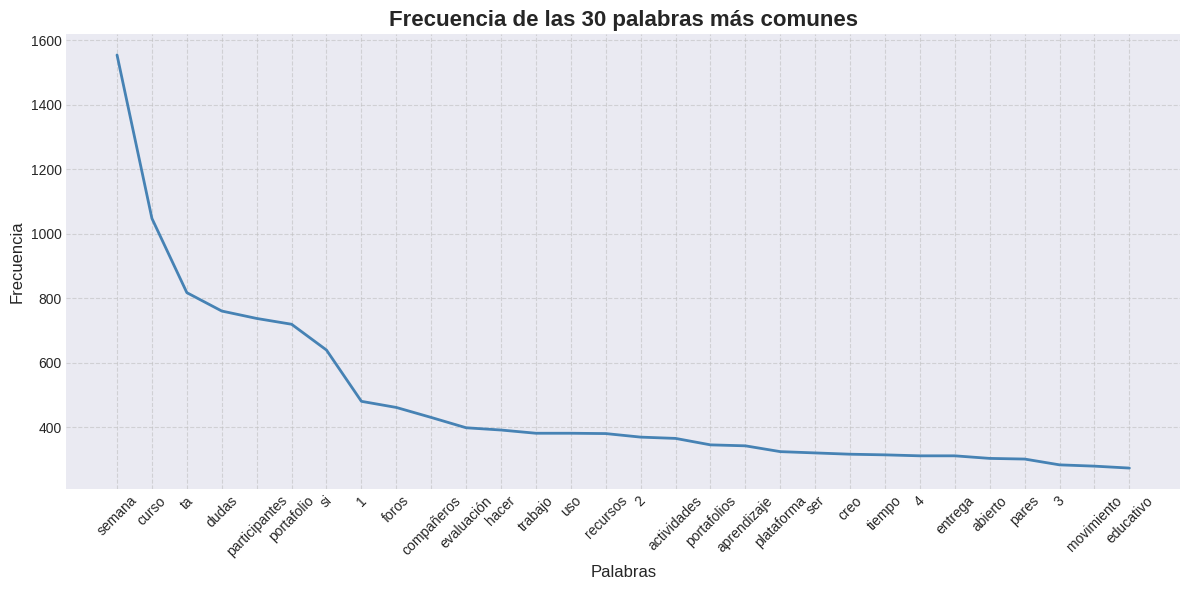

In [26]:
'''
Creación de los gráficos
'''

# Gráfico de barras para la frecuencia de palabras
plt.figure(figsize=(12, 6))
freq_dist.plot(30, cumulative=False, color='steelblue')
plt.title('Frecuencia de las 30 palabras más comunes', fontsize=16, fontweight='bold')
plt.xlabel('Palabras', fontsize=12)
plt.ylabel('Frecuencia', fontsize=12)
plt.xticks(rotation=45, fontsize=10)
plt.yticks(fontsize=10)
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

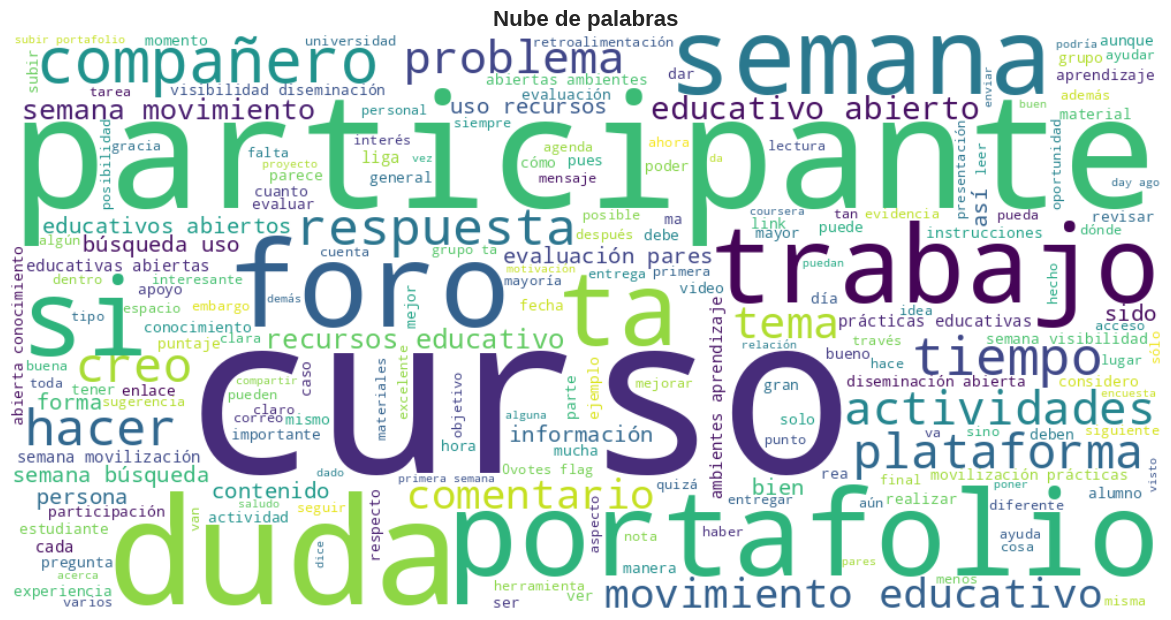

In [ ]:
# Nube de palabras estilizada
wordcloud = WordCloud(
    width=1000,
    height=500,
    background_color='white',
    colormap='viridis',
    max_words=200,
    contour_color='steelblue',
    contour_width=1.5
).generate(' '.join(filtered_words))

plt.figure(figsize=(12, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Nube de palabras', fontsize=16, fontweight='bold')
plt.tight_layout(pad=0)
plt.show()

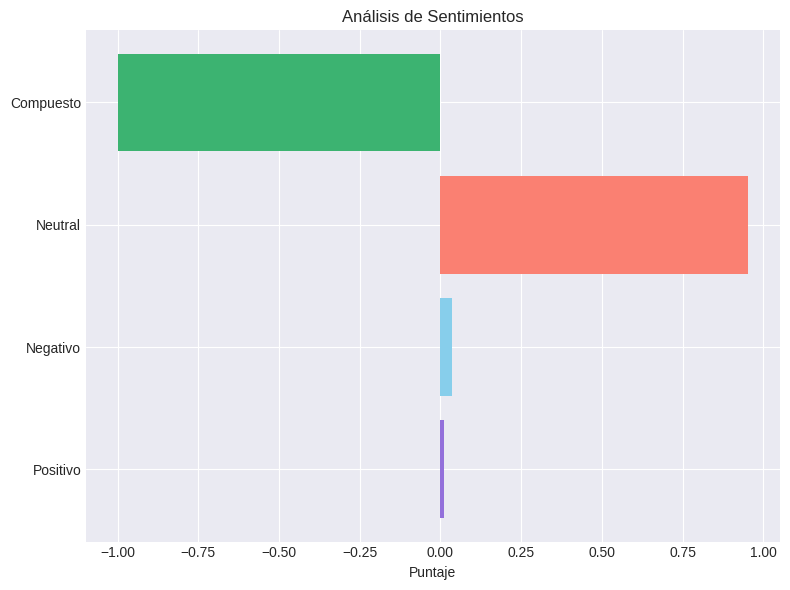

In [35]:
# Gráfico de sentimientos
labels = ['Positivo', 'Negativo', 'Neutral', 'Compuesto']
sizes = [sentimientos['pos'], sentimientos['neg'], sentimientos['neu'], sentimientos['compound']]

plt.figure(figsize=(8, 6))
plt.barh(labels, sizes, color=['mediumpurple', 'skyblue', 'salmon', 'mediumseagreen'])
plt.title('Análisis de Sentimientos')
plt.xlabel('Puntaje')
plt.tight_layout()
plt.show()